In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats

Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Supplemental Figure 8/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
hpoly = sc.read("../data/train_hpoly.h5ad")
hpoly

AnnData object with n_obs × n_vars = 5059 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [4]:
kang = sc.read("../data/train_pbmc.h5ad")
kang

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [13]:
def interpolation_plot(adata, cell_type, data_name, figure, conditions, cell_type_key):
    network = scgen.VAEArith(x_dimension=adata.shape[1], z_dimension=100, model_path=f"../models/scGen/{data_name}/{cell_type}/scgen")
    network.restore_model()
    
    cell_type_adata = adata[adata.obs[cell_type_key] == cell_type]
    cell_type_adata_ctrl = cell_type_adata[cell_type_adata.obs["condition"] == conditions["ctrl"]]
    net_train_data = adata[~((adata.obs[cell_type_key] == cell_type) & (adata.obs["condition"] == conditions["stim"]))]
    
    if data_name == "pbmc":
        cell_type_adata_ctrl.X = cell_type_adata_ctrl.X.A
        sc.tl.rank_genes_groups(cell_type_adata, groupby="condition", n_genes=10, method="wilcoxon")
        diff_genes = cell_type_adata.uns["rank_genes_groups"]["names"][conditions["stim"]].tolist()
    elif data_name == "hpoly":
        sc.tl.rank_genes_groups(cell_type_adata, groupby="condition", n_genes=10, method="wilcoxon")
        diff_genes = cell_type_adata.uns["rank_genes_groups"]["names"][conditions["stim"]].tolist()[:5] + cell_type_adata.uns["rank_genes_groups"]["names"][conditions["ctrl"]].tolist()[:5] 
    pred, delta = network.predict(net_train_data, conditions, cell_type_key, "condition", celltype_to_predict=cell_type)
    
    pred_adata = anndata.AnnData(pred, obs={"condition": ["pred"] * len(pred)},
                                 var={"var_names": cell_type_adata.var_names})
    all_adata = cell_type_adata.concatenate(pred_adata)
    ctrl = all_adata[all_adata.obs["condition"] == conditions["ctrl"]]
    pred_stim = all_adata[all_adata.obs["condition"] == "pred"]
    inter_cdm = sc.AnnData(network.linear_interpolation(ctrl, pred_stim, 2000))
    inter_cdm.var_names = adata.var_names
    if data_name == "pbmc":
        pred_stim.X = pred_stim.X.A
    all_adata = sc.AnnData(np.concatenate([cell_type_adata_ctrl.X, pred_stim.X, inter_cdm.X]))
    all_adata.obs["condition"] = ["ctrl"] * len(cell_type_adata_ctrl.X) + ["pred_stim"] * len(pred_stim) + \
                                 ["intermediate"] * len(inter_cdm.X)
    all_adata.var_names = cell_type_adata[3].var_names
    
    sc.tl.pca(all_adata)
    to_show  = "condition"
    sc.pl.pca(all_adata, color=to_show, save=f"_{data_name}_{cell_type}.pdf", show=True, frameon=False)
    os.rename(src=os.path.join(path_to_save, f"pca_{data_name}_{cell_type}.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig8{figure}_{data_name}_{cell_type}.pdf"))
    
    heatmap_data = inter_cdm[:, diff_genes].X
    col_names = diff_genes
    df = pd.DataFrame(heatmap_data)
    df.columns = col_names
    df.to_csv(os.path.join("./", cell_type+".txt"))

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen


... storing 'condition' as categorical


saving figure to file ../results/Figures/Supplemental Figure 8/pca_pbmc_CD4T.pdf


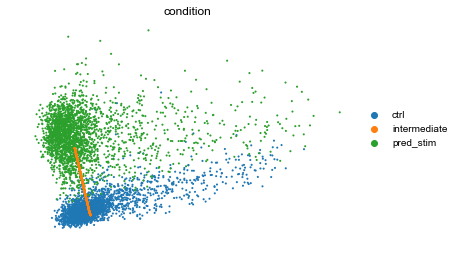

In [14]:
conditions = {"ctrl": "control", "stim": "stimulated"}
interpolation_plot(kang, "CD4T", "pbmc", "b", conditions, "cell_type")

INFO:tensorflow:Restoring parameters from ../models/scGen/hpoly/TA/scgen


... storing 'condition' as categorical


saving figure to file ../results/Figures/Supplemental Figure 8/pca_hpoly_TA.pdf


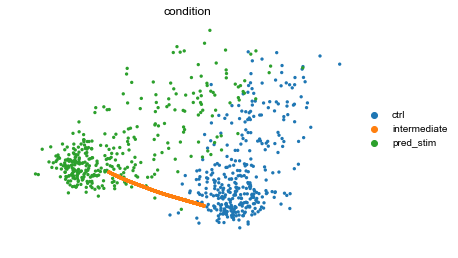

In [15]:
conditions = {"ctrl": "Control", "stim": "Hpoly.Day10"}
interpolation_plot(hpoly, "TA", "hpoly", "a", conditions, "cell_label")

In [16]:
%%bash
Rscript --vanilla SupplFig8.R

[1] 2000   11
[1] 2000   10
null device 
          1 
[1] 2000   11
[1] 2000   10
null device 
          1 



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
ComplexHeatmap version 1.18.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://bioconductor.org/packages/ComplexHeatmap/

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

